### Directly Download from GC and save as netcdf files
- This is for those who cannot use zarr/python for processing the CMIP6 datasets
- Please note that the netcdf files have CF-compliant time grids, but might not be what you are used to

In [468]:
import numpy as np
import pandas as pd
import os
import gcsfs #google cloud file system. 
import xarray as xr
import warnings
from glob import glob # use * !
import scipy.io as sio
import xesmf as xe

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

In [469]:
from utls import search_df, add_time_info, get_zdict #extra functions

### Initialization

In [470]:
def compute_area_and_seasonal_mean(danom, xlim, ylim, slim, mask=1):
    """
    Weights each grid point by the cos(latitude), computes area mean, normalizing by areaa mean of the weights
    returns:
        DataArray:  global mean for each model
        Here I'm making the xlims strictly positive
    """  
    danom = compute_seasonal_mean(danom, slim)
    danom = compute_area_mean(danom, xlim, ylim, mask)
    return danom
    
plev19 = [100000, 92500, 85000, 70000, 60000, 50000, 40000, 30000, 25000, 20000, 15000, 10000, 7000, 5000, 3000, 2000, 1000, 500, 100]
plev19_bnds = [100000,95000,90000,75000,65000,55000,45000,35000,27000,23000,17000,12500,8500,6500,4000,2500,1500,700,300,100]

In [471]:
def compute_area_mean(danom, xlim, ylim, mask=1):
    xlim = np.array(xlim)
    xlim += (xlim<0 )*360
    lon = danom.lon + (danom.lon < 0)*360
    if xlim[0]>xlim[1]:
        lon_sel = (lon>=xlim[0])+(lon<xlim[1])
    else:
        #this was previously wrong only when xlim was fully positive or negative -- missing parentheses
        lon_sel = (lon>=xlim[0])*(lon<xlim[1])
    danom = apply_mask(danom, mask)
    danom = danom.isel({'lat': (danom.lat>=ylim[0])*(danom.lat<ylim[1]), 
                        'lon': lon_sel,
                       })
    coslat = np.cos(np.deg2rad(danom.lat))
    weights = xr.ones_like(danom)*coslat
    weight_mean = weights.mean(['lat','lon'])#, keep_attrs=True, 'plev', 'time'
    area_mean = (danom * weights).mean(['lat','lon'], keep_attrs=True, skipna = True)#
    return area_mean/weight_mean

In [472]:
def apply_mask(danom, mask=1):
    if type(mask)!=int:
        mask = (xr.ones_like(danom)*mask)
        danom = danom.where(mask==1)
    return danom

In [473]:
def compute_seasonal_mean(danom, slim, mask=1): 
    danom = apply_mask(danom, mask)
    danom = danom.isel({
                    'time': (danom['time'].dt.month >= slim[0])*(danom['time'].dt.month <= slim[1])
                   })
    if not hasattr(danom.time, 'dt'):
        danom['time'] = danom.indexes['time'].year
        return danom.groupby('time').mean(dim='time', keep_attrs=True)
    else:   
        return danom.groupby(danom.time.dt.year).mean(dim='time', keep_attrs=True)
    
    #technically this is inconsistent handling; one makes a dimension called "time" and the other makes "years". I have to deal with that in my matlab code

In [474]:
#danom = ds0

#xlim = [-20,40]
#ylim = [12,18]
#slim = [7,9]
def calc_stp(dl):
    l = dl.values
    stp = max(l[1:] - l[0:-1])
    return stp

def compute_conv(danom, xlim, ylim, slim, plim):
    """
    Calculates the mean flow convergence of moisture on monthly scale into the Sahel region.
    returns convergence at each pressure level. add pressure level ranges to integrate over.
    """  
    xlim = np.array(xlim)
    xlim += (xlim<0)*360
    lt_stp = calc_stp(danom.lat)
    ln_stp = calc_stp(danom.lon)
    if xlim[0]>xlim[1]:
        lon_sel_2 = (danom.lon>(xlim[0]-ln_stp))+(danom.lon<(xlim[1]+ln_stp))
    else:
        lon_sel_2 = (danom.lon>(xlim[0]-ln_stp))*(danom.lon<(xlim+ln_stp))

    danom = danom.isel({'time': (danom['time'].dt.month >= slim[0])*(danom['time'].dt.month <= slim[1]),
                         'lat': (danom.lat>(ylim[0]-lt_stp))*(danom.lat<(ylim[1]+lt_stp)),
                         'lon': lon_sel_2,
                         'plev': danom.plev==plim #when I can figure out the bounds change this to an integral
                       })
    danom['qfu'] = danom['hus']*danom['ua']
    danom['qfv'] = danom['hus']*danom['va']
    if xlim[0]>xlim[1]:
        lon_sel = (danom.lon>xlim[0])+(danom.lon<xlim[1])
    else:
        lon_sel = (danom.lon>xlim[0])*danom.lon<xlim[1]
    lat_sel = (danom.lat>ylim[0])*(danom.lat<ylim[1])
    danom.load()
    dS = danom['qfv'].isel({'lat': danom.lat<(ylim[0]+lt_stp), 'lon': lon_sel}).mean(['lat'], keep_attrs=True)
    dN = -danom['qfv'].isel({'lat': danom.lat>(ylim[1]-lt_stp), 'lon': lon_sel}).mean(['lat'], keep_attrs=True)
    dW = danom['qfu'].isel({'lat': lat_sel, 'lon': danom.lon<(xlim[0]+ln_stp)}).mean(['lon'], keep_attrs=True)
    dE = -danom['qfu'].isel({'lat': lat_sel, 'lon': danom.lon>(xlim[1]-ln_stp)}).mean(['lon'], keep_attrs=True)
    coslat = np.cos(np.deg2rad(ylim))
    d_conv = (coslat[0]*dS + coslat[1]*dN).sum(['lon'], keep_attrs=True)+(dW+dE).sum(['lat'], keep_attrs=True)
    if d_conv.time.dtype!='datetime64[ns]':
        d_conv['time'] = d_conv.indexes['time'].year
        return d_conv.groupby('time').mean(dim='time', keep_attrs=True)
    else:   
        return d_conv.groupby(d_conv.time.dt.year).mean(dim='time', keep_attrs=True)

In [523]:
def update_vars(ds):
    for var in [var for var in ds.coords]:
        if 'bounds' in var:
            nvar = var.replace('bounds','bnds')
            #print(var,nvar)
            ds = ds.rename({var:nvar})
        if 'latitude' in var:
            nvar = var.replace('latitude','lat')
            #print(var,nvar)
            ds = ds.rename({var:nvar})
        if 'longitude' in var:
            nvar = var.replace('longitude','lon')
            #print(var,nvar)
            ds = ds.rename({var:nvar})
        if 'x' in var:
            nvar = var.replace('x', 'lon')
            ds = ds.rename({var:nvar})
        if 'y' in var:
            nvar = var.replace('y', 'lat')
            ds = ds.rename({var:nvar})
        if 'T' in var:
            nvar = var.replace('T', 'time')
            ds = ds.rename({var:nvar}) 
            
    if ('time' in ds.coords) and (not hasattr(ds.time.values[0], 'year')) and (not 'time' in str(type(ds0.T.values[0]))) and (not '64' in str(type(ds0.T.values[0]))):
        if not ds.time.calendar == '360' or not ds.time.attrs['units'].split()[0]=='months':
            print('cannot comprehend calendar: ', ds.time.calendar)
        else:
            ds['time'] = pd.to_datetime(ds.time*365.2422/12, unit='D', origin=np.datetime64(ds.time.attrs['units'].split()[-1]))
            
    return ds

In [476]:
# Where to write local netcdf files:
username = os.environ['JUPYTERHUB_USER']
mach = os.uname()[1]

#make a cmip5 file for checking that
zarr_local = f'/home/{username}/netcdf'
if not os.path.exists(zarr_local):
    print(f'Please create the directory {zarr_local}')
    

In [477]:
# This is the master CMIP6 Google Cloud catalog
cmip5 = True

if not cmip5:
    df_cloud = pd.read_csv('https://cmip6.storage.googleapis.com/cmip6-zarr-consolidated-stores-noQC.csv', dtype='unicode')
else:
    #df_cloud = pd.read_csv('https://cmip6.storage.googleapis.com/pangeo-cmip5.csv', dtype='unicode')
    df_cloud = pd.read_csv('strega_cmip5.csv', dtype='unicode')
    df_cloud.fillna('NA', inplace=True)
    
df_cloud.tail()

,activity_id,organization,experiment_id,var_domain,table_id,variable_id,source_id,member_id,fname,grid_label,zstore,institution_id
323,CMIP5,byScenario,NA,atmos,fixed,sftlf,MRI-AGCM3-2S,NA,sftlf.nc,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,MRI
324,CMIP5,byScenario,NA,atmos,fixed,sftlf,MRI-CGCM3,NA,sftlf.nc,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,MRI
325,CMIP5,byScenario,NA,atmos,fixed,sftlf,MRI-ESM1,NA,sftlf.nc,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,MRI
326,CMIP5,byScenario,NA,atmos,fixed,sftlf,NorESM1-M,NA,sftlf.nc,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,Nor
327,CMIP5,byScenario,NA,atmos,fixed,sftlf,NorESM1-ME,NA,sftlf.nc,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,Nor


### Choose basic configuration parameters

In [480]:
# Here we search the CMIP6 data for the datasets you need - using the same keywords as at the ESGF sites
#       https://esgf-node.llnl.gov/search/cmip6/

debug = False

# must choose ONE table_id  (only works for *mon or *day)
if cmip5:
    table_id = 'mon'
else:
    table_id = 'Amon'

#must choose LIST of experiments, variables
experiments = ['historical']#'hist-aer','hist-nat', 'hist-GHG']#, , 'piControl']# 'amip-hist', ]#
variables = ['ts']#'ua', 'va', 'hus'] #'zg', 'ta', 'hus', 'evspsbl', 'pr' #ts, #evspsbl, siconc

location = 'Ocean'#'Sahel'#

# can specify 'All' or give a list or string
#sources = ['NorESM2-LM', 'NorESM2-MM']#'EC-Earth3-LR']#'CAS-ESM2-0','IPSL-CM5A2-INCA','EC-Earth3-CC']
sources = 'All'
#members = ['r1i1p1f1']#'r9i1p1f2']#r3i1p1f1']#
members = 'All'

In [603]:
search = {'table_id':table_id}
search['experiment_id'] = experiments
search['variable_id'] = variables
if sources != 'All':
    search['source_id'] = sources
if members != 'All':
    search['member_id'] = members
    
df_available = search_df(df_cloud, **search)

print('number of matching datasets',len(df_available))

#523 historical simulations < 536 on the cite directly. Do I want to figure out which simulations are missing? 
# Or do I trust that they are missing for a reason?

number of matching datasets 187


In [604]:
df_available.head()

,activity_id,organization,experiment_id,var_domain,table_id,variable_id,source_id,member_id,fname,grid_label,zstore,institution_id
0,CMIP5,byScenario,historical,atmos,mon,ts,ACCESS1-0,r1i1p1,NA,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,ACCESS
1,CMIP5,byScenario,historical,atmos,mon,ts,ACCESS1-3,r1i1p1,NA,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,ACCESS
2,CMIP5,byScenario,historical,atmos,mon,ts,bcc-csm1-1,r2i1p1,NA,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,bcc
3,CMIP5,byScenario,historical,atmos,mon,ts,bcc-csm1-1,r1i1p1,NA,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,bcc
4,CMIP5,byScenario,historical,atmos,mon,ts,bcc-csm1-1,r3i1p1,NA,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,bcc


In [619]:
#only use the MASK code for TS!
if location=='Ocean':
    style = 'institution'#'source' #
    style_id = style+'_id'
    
    if(df_available.activity_id.values[0]=='CMIP5'):
        search_mask = {'table_id':'fixed'}#'SImon'}#
    else:
        search_mask = {'table_id':'fx'}#'SImon'}#
        
    search_mask['experiment_id'] = ['historical', 'piControl', '1pctCO2','hist-resIPO','hist-1950HC', 'NA']#'abrupt-4xCO2']#
    search_mask['variable_id'] = ['sftlf','siconc']
    if sources != 'All' and style=='source':
        search_mask['source_id'] = sources#['CESM1-CAM5']#
    if members != 'All':
        search_mask['member_id'] = members
    historical_mask = search_df(df_cloud, **search_mask)

    print('number of mask datasets',len(historical_mask))

number of mask datasets 55


In [621]:
historical_mask.head()

,activity_id,organization,experiment_id,var_domain,table_id,variable_id,source_id,member_id,fname,grid_label,zstore,institution_id
273,CMIP5,byScenario,NA,atmos,fixed,sftlf,ACCESS1-0,NA,sftlf.nc,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,ACCESS
274,CMIP5,byScenario,NA,atmos,fixed,sftlf,ACCESS1-3,NA,sftlf.nc,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,ACCESS
275,CMIP5,byScenario,NA,atmos,fixed,sftlf,bcc-csm1-1,NA,sftlf.nc,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,bcc
276,CMIP5,byScenario,NA,atmos,fixed,sftlf,bcc-csm1-1-m,NA,sftlf.nc,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,bcc
277,CMIP5,byScenario,NA,atmos,fixed,sftlf,BNU-ESM,NA,sftlf.nc,NA,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...,BNU


In [606]:
# For proper debugging, it is helpful to add time grid information to dataframe:
if debug:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        dfa = add_time_info(df_available)
else:
    dfa = df_available.copy()

In [609]:
#only use MASK code for TS!


if location=='Ocean':        
    historical_mask_models = set(historical_mask[[style_id, 'grid_label']].itertuples(index=False, name=None))
    sst_models = list(dfa[[style_id, 'grid_label']].itertuples(index=False, name=None))

    maskable_models = set(sst_models).intersection(historical_mask_models)
    usable = [model in maskable_models for model in sst_models]
    df_usable = dfa[usable]
    
    gsurls = np.array(df_usable.zstore)
    missing = np.array(dfa[np.invert(usable)].zstore)

    masks = historical_mask.groupby([style_id, 'grid_label']).first()

    print(gsurls)
    dfa = df_usable

['http://strega.ldeo.columbia.edu:81/CMIP5/.byScenario/.historical/.atmos/.mon/.ts/.CCSM4/.r5i1p1/.ts/dods'
 'http://strega.ldeo.columbia.edu:81/CMIP5/.byScenario/.historical/.atmos/.mon/.ts/.CCSM4/.r4i1p1/.ts/dods'
 'http://strega.ldeo.columbia.edu:81/CMIP5/.byScenario/.historical/.atmos/.mon/.ts/.CCSM4/.r6i1p1/.ts/dods'
 'http://strega.ldeo.columbia.edu:81/CMIP5/.byScenario/.historical/.atmos/.mon/.ts/.CCSM4/.r2i1p1/.ts/dods'
 'http://strega.ldeo.columbia.edu:81/CMIP5/.byScenario/.historical/.atmos/.mon/.ts/.CCSM4/.r1i1p1/.ts/dods'
 'http://strega.ldeo.columbia.edu:81/CMIP5/.byScenario/.historical/.atmos/.mon/.ts/.CCSM4/.r3i1p1/.ts/dods'
 'http://strega.ldeo.columbia.edu:81/CMIP5/.byScenario/.historical/.atmos/.mon/.ts/.CESM1-BGC/.r1i1p1/.ts/dods'
 'http://strega.ldeo.columbia.edu:81/CMIP5/.byScenario/.historical/.atmos/.mon/.ts/.CESM1-CAM5/.r2i1p1/.ts/dods'
 'http://strega.ldeo.columbia.edu:81/CMIP5/.byScenario/.historical/.atmos/.mon/.ts/.CESM1-CAM5/.r1i1p1/.ts/dods'
 'http://streg

In [610]:
masks

,,activity_id,organization,experiment_id,var_domain,table_id,variable_id,source_id,member_id,fname,zstore
institution_id,grid_label,,,,,,,,,,
NCAR,NA,CMIP5,byScenario,NA,atmos,fixed,sftlf,CESM1-CAM5,NA,sftlf.nc,http://strega.ldeo.columbia.edu:81/CMIP5/.bySc...


In [611]:
if location=='Ocean':
    print(missing)
    #print(sst_models.difference(maskable_models))

[]


In [612]:
# for pr:
if location=='Sahel':
    gsurls = np.array(dfa.zstore.values)

In [613]:
if debug:
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 1000)

    dm = dfa[['experiment_id','source_id','member_id','variable_id','start','stop']].groupby([
             'experiment_id','start','stop','source_id']).nunique()[['member_id']]

    table = pd.DataFrame.pivot_table(dm,
                                     values='member_id',
                                     index=['source_id','start','stop'],
                                     columns=['experiment_id'],
                                     aggfunc=np.sum,
                                     fill_value=0)
    print(table)

In [614]:
if not cmip5:
    I = dfa.issue_url.unique()
    if variable == 'ts':
        I = set(I).union(masks.issue_url.unique())
else:
    I = []
I

[]

In [615]:
if not cmip5:
    fs = gcsfs.GCSFileSystem(token='anon', access='read_only') #the actual files, not the list of files woohoo FILE SYSTEM
    #fs.get_mapper()

In [616]:
#gsurls = dfa.zstore.values #zstore is the url where the data is stored

ds_out = xe.util.grid_global(2, 4)

AL = True
conv = False
bndries = False
replace = False
start_month = 7
end_month = 9

ds_list = []
ds_failed_list = []

if conv:
    search_uv = search.copy()
    search_uv['source_id'] = [model]
    search_uv['member_id'] = [run]
    search_u = search_uv.copy()
    search_v = search_uv.copy()
    search_u['variable_id'] = ['ua']
    search_v['variable_id'] = ['va']
    
    
for row in dfa.iterrows():
    gsurl = row[1].zstore
    #zdict = get_zdict(gsurl, dfa) #naomi func for metadata TODO: LOL this is dumb why don't we just use the table so it doesn't get messed up????
    institution = row[1].institution_id #zdict['institution_id']
    model = row[1].source_id #zdict['source_id']
    source_dict = {'source':model, 'institution':institution}
    ensemble = row[1].activity_id.lower()
    if ensemble == 'cmip':
        ensemble = 'cmip6'
    try:
        grd = row[1].grid_label #zdict['grid_label']
    except(KeyError):
        grd = 'gn'
    run = row[1].member_id #zdict['member_id']
    variable = row[1].variable_id #zdict['variable_id']
    expt = row[1].experiment_id #zdict['experiment_id']
    if conv:
        filename = f'{variable}_conv_925_{institution}_{model}_{run}'
    elif bndries:
        filename = f'{variable}_bndries_{institution}_{model}_{run}'
    elif AL:
        filename = f'global{variable}_{institution}_{model}_{run}'
    else:
        filename = f'{variable}_{institution}_{model}_{run}'
    ncdir = f'{zarr_local}/{ensemble}/preprocessed/{expt}/various'#{start_month}-{end_month}'
    ncfile = f'{ncdir}/{filename}.nc'
    
#move replace back to here
    
    if(not replace):
        ncfiles = glob(ncfile) #check not to double-download files
        if len(ncfiles) > 0:
            print(ncfiles, 'already exists')
            continue
            
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        #TODO: NEED TO CHANGE THIS FOR CMIP5
        if(df_available.activity_id.values[0]=='CMIP5'):
            ds0 = xr.open_dataset(gsurl,decode_times=False)
            if variable=='ts':
                d_s = historical_mask[historical_mask[style_id]==source_dict[style]]
                M2 = d_s.source_id.values[0]
                mask_ds = xr.open_dataset(d_s.zstore.values[0],decode_times=False)
        else:
            ds0 = xr.open_zarr(fs.get_mapper(gsurl),consolidated=True) #gets info about the file. get_mapper! always use consolidated=True
            if variable=='ts':
                mask_ds = xr.open_zarr(fs.get_mapper(masks['zstore'][(source_dict[style], grd)]),consolidated=True)
                if style != 'source':
                    M2 = masks['source_id'][(source_dict[style],grd)]
                else:
                    M2 = model
        if (variable=='ts') and not M2==model:
            print(model, ' will be masked by ', M2)
                
        #if variable=='ta' or variable=='zg':
         #   ds0 = ds0.isel({'plev': ds0.plev==100})
        if conv:
            U = np.array(search_df(df_cloud, **search_u).zstore.values)
            V = np.array(search_df(df_cloud, **search_v).zstore.values)
            if len(U) == 1 and len(V) == 1:
                dsU = xr.open_zarr(fs.get_mapper(U[0]),consolidated=True)
                dsV = xr.open_zarr(fs.get_mapper(V[0]),consolidated=True)
                ds0['va'] = dsV['va']
                ds0['ua'] = dsU['ua']
            else:
                continue
        
    #month_length = ds.time.dt.days_in_month #for some reason the first one doesn't have this...
        
    ds0 = update_vars(ds0)
    
    if location=='Ocean':
        mask_ds = update_vars(mask_ds)
        if (ds0.lat.size != mask_ds.lat.size) or (ds0.lon.size != mask_ds.lon.size):
            print('incompatible mask for', model, run)
            continue
        S = sum(ds0.lat.values.round() == mask_ds.lat.values.round())
        if S != ds0.lat.size:
            S2 = sum(ds0.lat.values.round()==mask_ds.lat.values.round()[::-1])
            if S2 == ds0.lat.size:
                mask_ds = mask_ds.reindex(lat=mask_ds.lat[::-1])
            else:
                print('dimension mismatch:', S, '!=', ds0.lat.size, '. Skipping', model, run)
                #continue
        #need to come up with a systematic way of catching when the mask needs to be flipped.
        ls_mask = np.floor(1-mask_ds.sftlf.values/mask_ds.sftlf.values.max())#np.flip(, axis=0)
        new_lon = (ds0.lon+180)%360-180
        new_mask = (ds0.lat>4)*(6*ds0.lat - 5*new_lon <164) + (ds0.lat<4)*(6*ds0.lat + 5*new_lon > -116)
        if hasattr(S, 'values'):
                S = S.values
        new_mask = new_mask.values #xr.ones_like(ds0)*
    
    try:
        #if variable=='hus':
        #    ds = ds0.isel({'plev':ds0.plev==8.5e4})
        #else:
        ds = ds0
        #THINGS THAT WERE WRONG: NA, TA, W and E
        if location=='Ocean':
            if AL:
                Sm = compute_seasonal_mean(ds, [start_month, end_month], mask = ls_mask)
                regridder = xe.Regridder(Sm, ds_out, "bilinear", reuse_weights=True, periodic=True)
                Sm = regridder(Sm['ts']).to_dataset()
            else:
                #TODO don't assume it's ts. make NARI and p1 only for ts.
                #El Nino, peaks in winter.
                Sm = compute_area_and_seasonal_mean(ds, [140,-80],[-20,20],[1, 3], mask=ls_mask)
                Sm = Sm.rename_vars({'ts':'EN'})
                #Atlantic Meridional Mode. Peaks in MAM.
                Sm['AMM'] = compute_area_and_seasonal_mean(ds, [-60,-15], [10,20], [3, 5]).ts #5,15                
                #Gulf of Gunea. area defined by Keys, season defined by Lele.
                Sm['GG'] = compute_area_and_seasonal_mean(ds, [-28,20], [-35,15], [5, 6], mask=ls_mask*new_mask).ts
                #JAS indices, beginning with the Pacific, which includes the Carribean Sea. 
                JAS = compute_seasonal_mean(ds, [7,9])
                Sm['Pc'] = compute_area_mean(JAS, [140,-60],[-20,20], mask=ls_mask).ts
                Sm['TA'] = compute_area_and_seasonal_mean(ds, [-60,-15], [10,20], [7, 9]).ts #5,15                
                #Tropical Atlantic Sea Breeze, area defined by Lele given JAS
                #this is actually cutting it super close to the AN/cold tongue thing. Perhaps I should lose this, just use Ale's SA, change TA to AMM and add back TA.
                Sm['SB'] = compute_area_mean(JAS, [-30,20], [0,10], mask=ls_mask).ts
                #North Atlantic
                Sm['NA'] = compute_area_mean(JAS, [-75,-15], [20,40]).ts #Ale's: 10:40 doesn't need mask
                #South Atlantic (combine with SB to get ale's SA). The full SA should roughly capture the Atlantic Nino, which peaks in JJA (678)
                Sm['SA'] = compute_area_mean(JAS, [-30, 20], [-20,10], mask=ls_mask).ts
                #Indian Ocean
                Sm['IN'] = compute_area_mean(JAS, [40,100],[-20,20], mask=ls_mask).ts
                #Phillipines
                Sm['Ph'] = compute_area_mean(JAS, [100,140],[-20,20], mask=ls_mask).ts
                #Global Tropics
                Sm['GT'] = compute_area_mean(JAS, [0,360],[-20,20], mask=ls_mask).ts
                #South Atlantic Leftovers to GT
                Sm['L'] = compute_area_mean(JAS, [-60,-30],[-20,0], mask=ls_mask).ts
                # mediterranean
                Sm['md'] = compute_area_mean(JAS, [-6,36], [30,40], mask=ls_mask).ts
                if(variable=='ts'):
                    Sm['NARI'] = Sm['NA'] + Sm['TA']- Sm['GT'] 
                    Sm['p1'] = Sm['NA'] +Sm['TA']+ Sm['GT'] 
                    
        elif conv:
            Sm = compute_conv(ds, [-20,40], [12,18], [start_month, end_month], 92500)
        elif bndries:
            if variable!='ua':
                S = compute_area_and_seasonal_mean(ds, [-20,40], [12-calc_stp(ds.lat), 12], [start_month, end_month])
                N = compute_area_and_seasonal_mean(ds, [-20,40], [18, 18+calc_stp(ds.lat)], [start_month, end_month])
            if variable!='va':
                W = compute_area_and_seasonal_mean(ds, [-20-calc_stp(ds.lon), -20], [12,18], [start_month, end_month])
                E = compute_area_and_seasonal_mean(ds, [40, 40+calc_stp(ds.lon)], [12,18], [start_month, end_month])
            if variable=='ua':
                Sm = W.rename_vars({variable:(variable+'_West')})
                Sm[variable+'_East'] = E[variable]
            else:
                Sm = S.rename_vars({variable:(variable+'_South')})
                Sm[variable+'_North'] = N[variable]
                if variable!= 'va':
                    Sm[variable+'_West'] = W[variable]
                    Sm[variable+'_East'] = E[variable]
        else:
            Sm = compute_area_and_seasonal_mean(ds, [-20,40], [12,18], [start_month, end_month])
  
    except ValueError:
        print(f'value error for {ncfile}')
        ds_failed_list += [ds]
        continue
    #have to customize this to the variable I'm using!
    unts = ds[variable].attrs['units']
    if (variable=='ts') or (variable=='tas') or (variable=='ta'):
        if not (unts=='K' or unts == 'Kelvin_scale'):
            print("cannot comprehend units ({}), skipping model {}".format(ds[variable].attrs['units'], model))
            continue
    elif (variable=='pr') or (variable=='evspsbl'):
        if unts == 'kg m-2 s-1':
            Sm *= 86400
        else:
            print("cannot comprehend units ({}), skipping model {}".format(ds.pr.attrs['units'], model))
            continue
    elif variable=='zg':
        if not unts=='m':
            print("cannot comprehend units ({}), skipping model {}".format(ds[variable].attrs['units'], model))
            continue
    elif (variable=='huss') or (variable=='hus'):
        Sm *= 1000/float(unts) #convert to g/kg WHY DID I DO THIS?!
    elif (variable=='va' or variable=='ua'):
        if not ((unts=='m/s') or (unts=='m s-1')):
            print("cannot comprehend units ({}), skipping model {}".format(ds[variable].attrs['units'], model))
            continue
    else:
        print("need to make new units case for variable {} with units {}".format(variable, unts))

    os.system(f'mkdir -p {ncdir}')

    try:
        Sm.to_netcdf(ncfile,mode='w',unlimited_dims=['time','year'])  #saves the file. Don't have to do this before I'm ready! But ds is replaced each time...
        ds_list += [Sm]
        print(f'saving file {ncfile}')
    except ValueError:
        print(f'value error for {ncfile}')
        ds_failed_list += [Sm]
        continue    
        
    #ok I got an error for a model which uses i/j coordinates instead of lat lon! OY VEY...
    
    #force it to replace ['/home/rebecca/netcdf/cmip6/preprocessed/hist-nat/7-9/ts_IPSL_IPSL-CM6A-LR_r1i1p1f1.nc'] already exists

['/home/rebecca/netcdf/cmip5/preprocessed/historical/various/globalts_NCAR_CCSM4_r5i1p1.nc'] already exists
['/home/rebecca/netcdf/cmip5/preprocessed/historical/various/globalts_NCAR_CCSM4_r4i1p1.nc'] already exists
['/home/rebecca/netcdf/cmip5/preprocessed/historical/various/globalts_NCAR_CCSM4_r6i1p1.nc'] already exists
['/home/rebecca/netcdf/cmip5/preprocessed/historical/various/globalts_NCAR_CCSM4_r2i1p1.nc'] already exists
['/home/rebecca/netcdf/cmip5/preprocessed/historical/various/globalts_NCAR_CCSM4_r1i1p1.nc'] already exists
['/home/rebecca/netcdf/cmip5/preprocessed/historical/various/globalts_NCAR_CCSM4_r3i1p1.nc'] already exists
['/home/rebecca/netcdf/cmip5/preprocessed/historical/various/globalts_NCAR_CESM1-BGC_r1i1p1.nc'] already exists
['/home/rebecca/netcdf/cmip5/preprocessed/historical/various/globalts_NCAR_CESM1-CAM5_r2i1p1.nc'] already exists
['/home/rebecca/netcdf/cmip5/preprocessed/historical/various/globalts_NCAR_CESM1-CAM5_r1i1p1.nc'] already exists
['/home/rebecc

In [ ]:
tids = df_cloud['variable_id']
vids = df_cloud['grid_label']
set([vids[i] for i in range(len(tids)) if tids[i]=='siconc'])
#df_cloud['table_id'].unique()

In [311]:
Sm.to_netcdf(ncfile,mode='w')

In [617]:
ds0

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, time: 1872)
Coordinates:
  * lat      (lat) float32 -90.0 -88.10526 -86.210526 ... 88.10526 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1850-01-16T05:14:31.902460800 ... 2005-12-16T13:30:00
Data variables:
    ts       (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [618]:
mask_ds

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
Data variables:
    sftlf    (lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [395]:
ds0.lat.values.round() == mask_ds.lat.values.round()

/home/naomi/.conda/envs/my3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

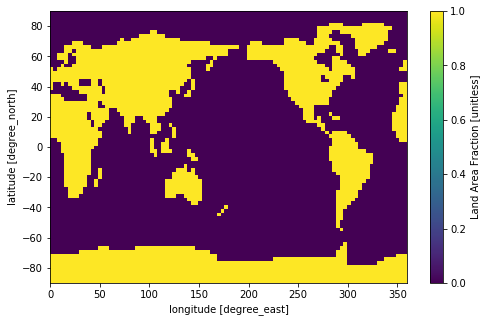

In [554]:
#mask_ds = xr.open_zarr(fs.get_mapper(masks['zstore'][(source_dict[style], grd)]),consolidated=True)
#mask_ds = update_vars(mask_ds)
mask_ds.sftlf.plot()

In [286]:
S = sum(ds0.lat.values.round() == mask_ds.lat.values.round())
S2 = sum(ds0.lat.values.round()==mask_ds.lat.values.round()[::-1])
S2

160

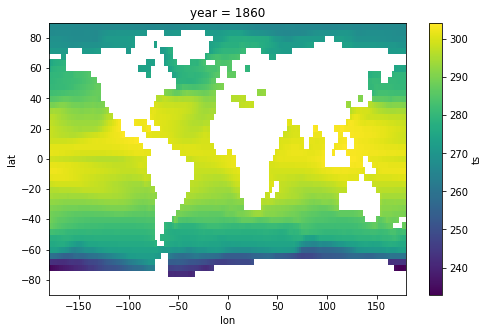

In [582]:
Sm.ts[0].plot(x="lon",y="lat")

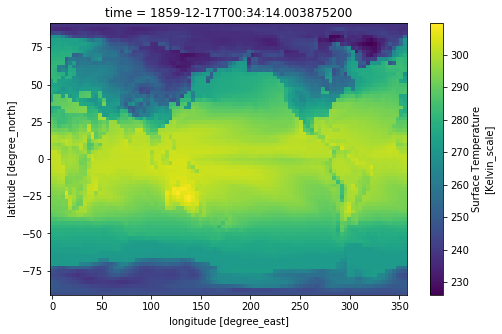

In [571]:
ds0.ts[0].plot()

In [551]:
mask_ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 96)
Coordinates:
  * lon      (lon) float32 1.875 5.625 9.375 13.125 ... 350.625 354.375 358.125
  * lat      (lat) float32 -88.76711 -86.30136 -83.83561 ... 86.30138 88.76713
Data variables:
    sftlf    (lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [529]:
ds_out

<xarray.Dataset>
Dimensions:  (x: 180, x_b: 181, y: 45, y_b: 46)
Coordinates:
    lon      (y, x) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
    lat      (y, x) float64 -88.0 -88.0 -88.0 -88.0 ... 88.0 88.0 88.0 88.0
    lon_b    (y_b, x_b) int64 -180 -178 -176 -174 -172 ... 172 174 176 178 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [185]:
new_mask = (mask_ds.lat>4)*(6*mask_ds.lat - 5*new_lon <164) + (mask_ds.lat<4)*(6*mask_ds.lat + 5*new_lon > -116)
new_mask

<xarray.DataArray (lat: 160, lon: 320)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat      (lat) float64 89.14 88.03 86.91 85.79 ... -86.91 -88.03 -89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9

In [ ]:
ds0 = xr.open_dataset(gsurl,decode_times=False)
mask_ds = xr.open_dataset(historical_mask[historical_mask.source_id==model].zstore.values[0],decode_times=False)
ds0.T
ds0 = update_vars(ds0)
mask_ds = update_vars(mask_ds)
ls_mask = np.floor(1-mask_ds.sftlf.values/100)
mask = ls_mask
ds = ds0
Sm = compute_seasonal_mean(ds, [7, 9], mask = ls_mask)
Sm
#Sm.ts[0].plot()

In [ ]:
analysis_url = 'http://strega.ldeo.columbia.edu:81/expert/CMIP5/.byScenario/.historical/.atmos/.mon/.ts/.NorESM1-ME/.r1i1p1/.ts/SOURCES/.WORLDBATH/.bath/X/%28lon%29renameGRID/Y/%28lat%29renameGRID%5Blon/lat%5DregridLinear/0/maskgt/0/mul/add//time//T/renameGRID/T/1/monthlyAverage/T/%28Jul-Sep%29seasonalAverage/T/12/STEP/dods'
ds_comp = xr.open_dataset(analysis_url, decode_times=False)
ds_comp = update_vars(ds_comp)
#ds_comp.asum[0].plot()
ds_comp




    for var in [var for var in ds.coords]:
        if 'bounds' in var:
            nvar = var.replace('bounds','bnds')
            #print(var,nvar)
            ds = ds.rename({var:nvar})

In [ ]:
        Sm.to_netcdf(ncfile,mode='w',unlimited_dims=['time','year'])  #saves the file. Don't have to do this before I'm ready! But ds is replaced each time...


In [59]:
ds.time.dt.year

<xarray.DataArray 'year' (time: 10212)>
array([4150, 4150, 4150, ..., 5000, 5000, 5000])
Coordinates:
  * time     (time) object 4150-01-16 12:00:00 ... 5000-12-16 12:00:00

In [56]:
Sm = compute_area_and_seasonal_mean(ds, [140,-80],[-20,20],[1, 3], mask=ls_mask)
compute_seasonal_mean(ds, [1,3], mask=ls_mask)

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 90, lon: 144, year: 851)
Coordinates:
    lon_bnds  (lon, bnds) float64 0.0 2.5 2.5 5.0 ... 355.0 357.5 357.5 360.0
    lat_bnds  (lat, bnds) float64 -90.0 -88.0 -88.0 -86.0 ... 88.0 88.0 90.0
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * year      (year) int64 4150 4151 4152 4153 4154 ... 4996 4997 4998 4999 5000
Dimensions without coordinates: bnds
Data variables:
    ts        (year, lat, lon) float32 dask.array<chunksize=(1, 90, 144), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.3.2
    contact:                Kenneth Lo (cdkkl@giss.nasa.gov)
    creation_date:          2018-08-24T12:18:46Z
    data_specs_version:     01.00.23
    experimen

In [ ]:
Sm = compute_seasonal_mean(ds, [start_month, end_month], mask = ls_mask)
Sm.ts[0].plot()

In [ ]:
mask_ds.sftlf.values.max()

In [ ]:
((mask_ds.sftlf>mask_ds.sftlf.values.min())*xr.ones_like(ds)).ts[time=1901]

In [ ]:
mask_ds

In [ ]:
mask_ds.sftlf.values[5:10,5:10]

In [ ]:
            Sm = compute_area_and_seasonal_mean(ds, [-20,40], [12-calc_stp(ds.lat), 12], [start_month, end_month])
            Sm = Sm.rename_vars({variable:(variable+'_South')})
            N = compute_area_and_seasonal_mean(ds, [-20,40], [18, 18+calc_stp(ds.lat)], [start_month, end_month])
            Sm[variable+'_North'] = N[variable]
            W = compute_area_and_seasonal_mean(ds, [-20-calc_stp(ds.lon), -20], [12,18], [start_month, end_month])
            Sm[variable+'_West'] = W[variable]
            E = compute_area_and_seasonal_mean(ds, [40, 40+calc_stp(ds.lon)], [12,18], [start_month, end_month])
            Sm[variable+'_East'] = E[variable]

In [ ]:
slim = [start_month, end_month]

In [ ]:
T = 0
F = 0
c = 0
for i in range(96):
    T += danom.lat[i] == mask.lat[i]
    F += danom.lat[i] != mask.lat[i]
    c += 1
T

In [ ]:
#ds0
#new_mask
#sum(ds0.lat == new_mask.lat)
Sm

In [ ]:
xr.ones_like(danom)*mask.values

In [ ]:
diffs = danom.lat.values - mask.lat.values
diffs[danom.lat.values != mask.lat.values]

In [ ]:
mask.lat.values[danom.lat.values != mask.lat.values]

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
#plt.rcParams['figure.figsize'] = (8,5)
#masked = ds0*xr.ones_like(ds0)*ls_mask
#masked = masked.isel({'lat': (masked.lat>-35)*(masked.lat<15),'lon': (masked.lon>-28)*(masked.lon<20)})
#masked['ts'] = masked['ts'] - 273
#new_mask = (masked.lat>4)*(6*masked.lat - 5*masked.lon <164) + (masked.lat<4)*(6*masked.lat + 5*masked.lon > -116)
#(masked*xr.ones_like(masked)*new_mask).ts[0].sortby(masked.lon).plot()
Sm.ts.isel({'time':Sm.time == Sm.time(0)})

In [ ]:
gsurl

In [ ]:
Sm.GT.plot()

In [ ]:
ds_out = xe.util.grid_global(1, 2)
regridder = xe.Regridder(Sm, ds_out, "nearest_s2d")
Sm_out = regridder(Sm['ts'])
Sm_out[0].plot()

In [ ]:
! tree -L 9 ~/CMIP6-downloads #unix tree of created files; I didn't create any.

In [ ]:
! du -sh ~/CMIP6-downloads/*/*/*/*

In [ ]:
ds = xr.open_dataset('/home/naomi/CMIP6-downloads/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/sfcWind/gn/sfcWind.nc')

In [ ]:
ds.sfcWind.plot(vmin=0,vmax=12)

In [ ]:
#Convert longitude coordinates from 0-359 to -180-179:

ds2 = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')

#or

ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
ds = ds.sortby(ds.lon)

In [ ]:
ds0

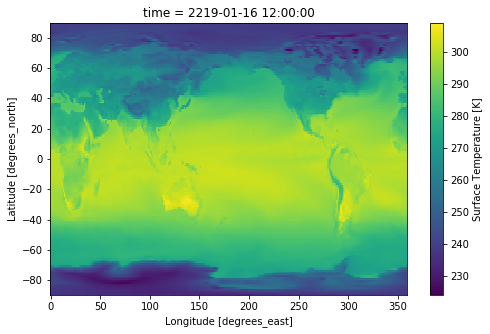

In [271]:
ds0.ts[0].plot()

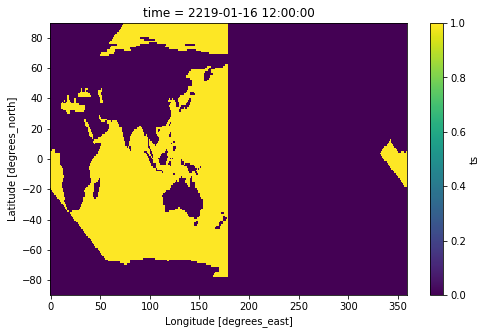

In [427]:
(xr.ones_like(ds0.ts[0])*new_mask*ls_mask).plot()